In [86]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
smoke_test = ('CI' in os.environ)

## Univariate 

In [2]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
exp_transform = T.ExpTransform()

In [3]:
dist_y = dist.TransformedDistribution(dist_x, [exp_transform])

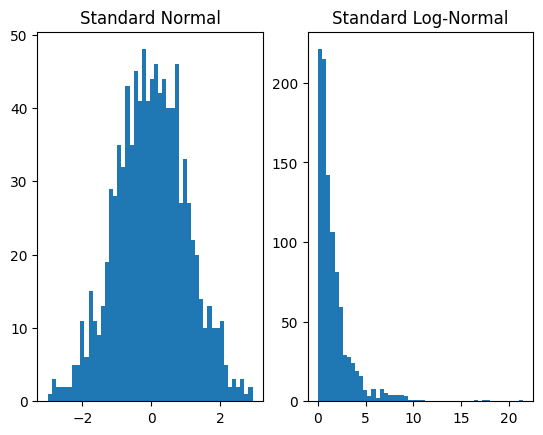

In [4]:
plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Standard Log-Normal')
plt.show()

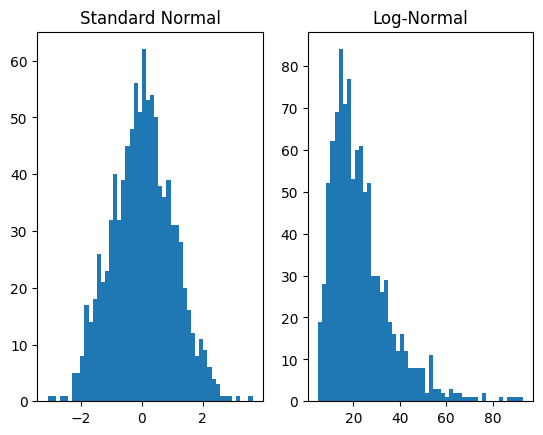

In [5]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
affine_transform = T.AffineTransform(loc=3, scale=0.5)
exp_transform = T.ExpTransform()
dist_y = dist.TransformedDistribution(dist_x, [affine_transform, exp_transform])

plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show()

## Multivariate

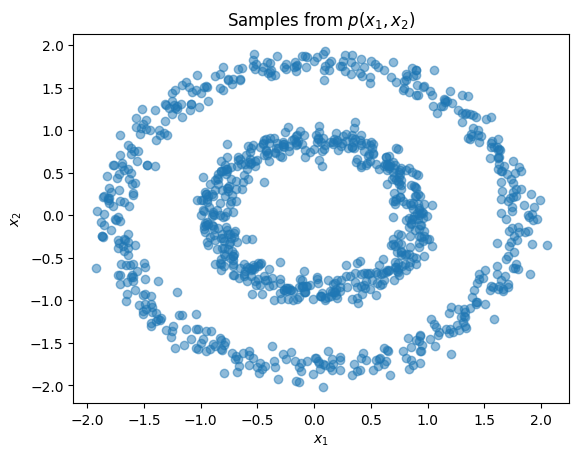

/home/jupyter-aquach@broadinstit-9cd67/aquach/deepscm/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/jupyter-aquach@broadinstit-9cd67/aquach/deepscm/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


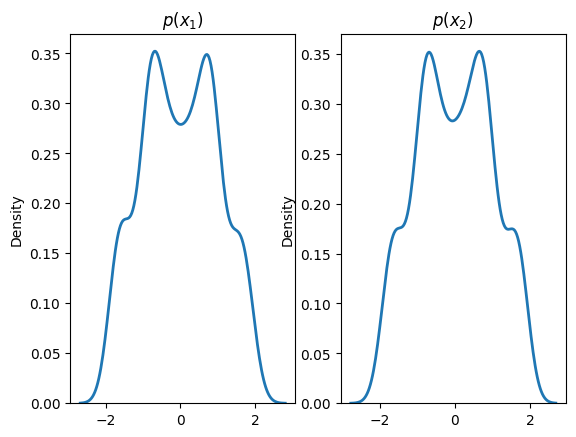

In [6]:

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

In [16]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.Spline(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [17]:
%%time
steps = 1 if smoke_test else 1001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 4.378643989562988
step: 200, loss: 1.365424633026123
step: 400, loss: 1.3075852394104004
step: 600, loss: 1.2861191034317017
step: 800, loss: 1.2774651050567627
step: 1000, loss: 1.2740371227264404
CPU times: user 3min 25s, sys: 991 ms, total: 3min 26s
Wall time: 8.07 s


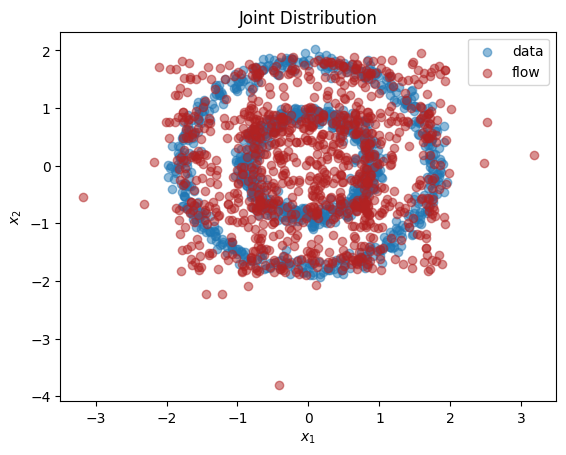

/home/jupyter-aquach@broadinstit-9cd67/aquach/deepscm/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/jupyter-aquach@broadinstit-9cd67/aquach/deepscm/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/jupyter-aquach@broadinstit-9cd67/aquach/deepscm/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be 

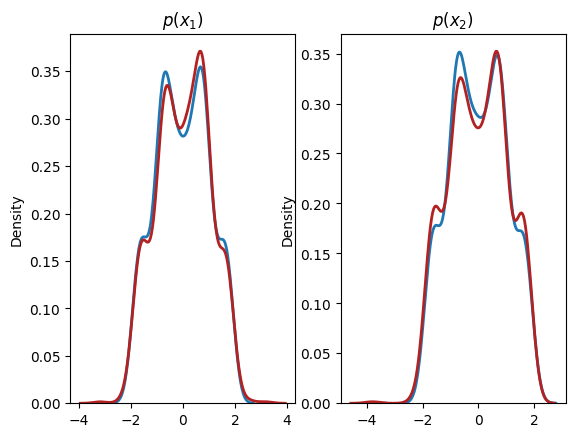

In [18]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

In [19]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [20]:
%%time
steps = 1 if smoke_test else 5001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 6.59057092666626


KeyboardInterrupt: 

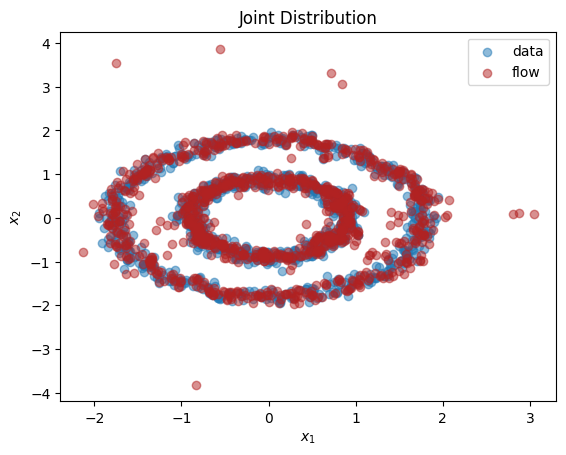

/home/jupyter-aquach@broadinstit-9cd67/aquach/deepscm/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/jupyter-aquach@broadinstit-9cd67/aquach/deepscm/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/jupyter-aquach@broadinstit-9cd67/aquach/deepscm/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be 

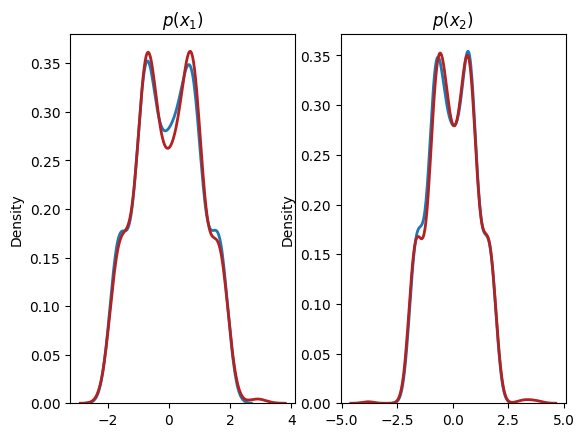

In [ ]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

In [ ]:
dist_base = dist.Normal(torch.zeros(1), torch.ones(1))
x1_transform = T.spline(1)
dist_x1 = dist.TransformedDistribution(dist_base, [x1_transform])
x2_transform = T.conditional_spline(1, context_dim=1)
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [x2_transform])
x1 = torch.ones(1)
print(dist_x2_given_x1.condition(x1).sample())

%%time
steps = 1 if smoke_test else 5001
modules = torch.nn.ModuleList([x1_transform, x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)
x1 = dataset[:,0][:,None]
x2 = dataset[:,1][:,None]
for step in range(steps):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(x1)
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(x1.detach()).log_prob(x2.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

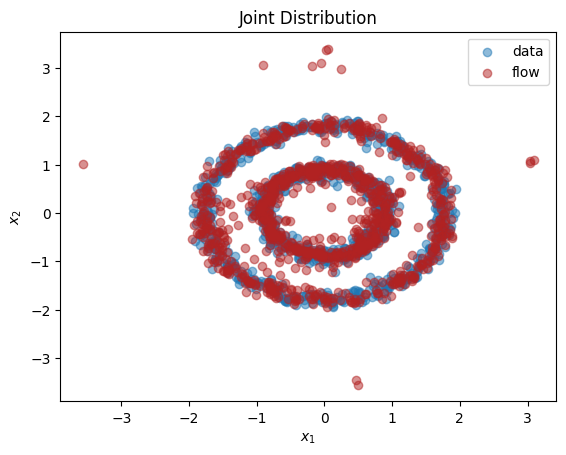

/home/jupyter-aquach@broadinstit-9cd67/aquach/deepscm/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/jupyter-aquach@broadinstit-9cd67/aquach/deepscm/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/jupyter-aquach@broadinstit-9cd67/aquach/deepscm/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be 

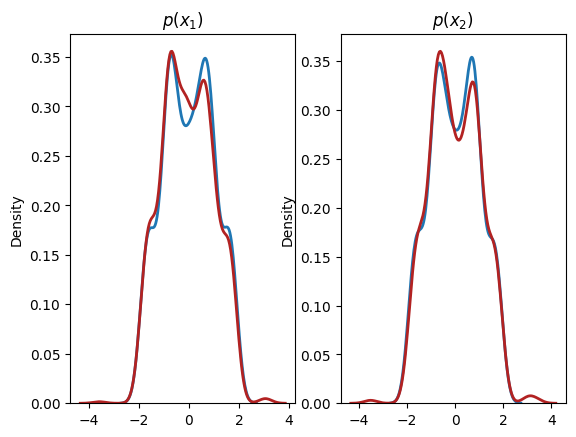

In [ ]:
X = torch.cat((x1, x2), dim=-1)
x1_flow = dist_x1.sample(torch.Size([1000,]))
x2_flow = dist_x2_given_x1.condition(x1_flow).sample(torch.Size([1000,]))
X_flow = torch.cat((x1_flow, x2_flow), dim=-1)

plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

## NF with Celeba

In [84]:
%cd /dgx1nas1/storage/data/aquach/deepscm
%pwd

/dgx1nas1/storage/data/aquach/deepscm


'/dgx1nas1/storage/data/aquach/deepscm'

In [87]:

from deepscm.datasets.medical.celeba import CelebaEmbedDataset

# from torch.utils.data import Dataset

# class CelebaEmbedDataset(Dataset):
#     def __init__(self, npy_path, csv_path):
#         super().__init__()
#         self.npy_path = npy_path
#         self.csv_path = csv_path

#         self.embed = np.load(npy_path)
#         df = pd.read_csv(csv_path).drop(columns=['image_id'])
#         self.metrics = {col: torch.as_tensor(df[col]).float() for col in df.columns}

#         self.num_items = len(self.embed)


#     def __len__(self):
#         return self.num_items


#     def __getitem__(self, index):
#         item = {col: values[index] for col, values in self.metrics.items()}
#         item['embed'] = self.embed[index]

#         return item

split_dir = "./assets/data/celeba"
celeba_train = CelebaEmbedDataset(npy_path=f'{split_dir}/train_features.npy', csv_path=f'{split_dir}/train_features.csv')
celeba_val = CelebaEmbedDataset(npy_path=f'{split_dir}/val_features.npy', csv_path=f'{split_dir}/val_features.csv')
celeba_test = CelebaEmbedDataset(npy_path=f'{split_dir}/test_features.npy', csv_path=f'{split_dir}/test_features.csv')

In [88]:
len(celeba_train)

39

In [89]:
import pandas as pd
df = pd.read_csv(f'{split_dir}/train_features.csv')
df.shape

(162770, 43)

In [90]:
arr = np.load(f'{split_dir}/train_features.npy')
arr.shape

(162770, 384)

In [91]:
x = next(iter(celeba_train))
x['embed'].shape

(384,)

In [92]:
from torch.utils.data.dataloader import DataLoader
dl = DataLoader(dataset=celeba_train, batch_size=32, shuffle=True, drop_last=True)
# class BatchDataLoader(DataLoader):
#     def __init__(self, batches):
#         self.batches = batches

#     def __iter__(self):
#         for batch in self.batches:
#             yield batch

#     def __len__(self):
#         return len(self.batches)

In [93]:
len(celeba_train)
print(next(iter(celeba_train))['embed'].shape)

(384,)


In [94]:
q['embed'].shape

torch.Size([32, 384])

In [95]:
%%time
from pyro.distributions import Normal, Bernoulli, TransformedDistribution

# Model Sex
sex_dist = Bernoulli(logits=0.5)
sex = pyro.sample('sex', sex_dist).reshape(-1)
print(sex)

# Model Facial Hair as Normal(0, 1)
facial_hair_dist_base = dist.Normal(torch.zeros(1), torch.ones(1))
facial_hair_transform = T.spline(1)
facial_hair_dist = dist.ConditionalTransformedDistribution(facial_hair_dist_base, [facial_hair_transform])
# facial_hair_dist = dist.ConditionalTransformedDistribution(facial_hair_dist_base, [facial_hair_transform]).condition(sex)
# facial_hair = pyro.sample('facial_hair', facial_hair_dist)
# facial_hair_ = facial_hair_transform.inv(facial_hair)

# Model Embedding
embedding_dist_base = dist.Normal(torch.zeros(384), torch.ones(384))
embedding_transform = T.spline(384)
embedding_context = torch.cat([sex, facial_hair_], -1)
embedding_dist = dist.ConditionalTransformedDistribution(embedding_dist_base, [embedding_transform])
# embedding_dist = dist.ConditionalTransformedDistribution(embedding_dist_base, [embedding_transform]).condition(embedding_context)

# steps = 1 if smoke_test else 5001
modules = torch.nn.ModuleList([facial_hair_transform, embedding_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)
# x1 = dataset[:,0][:,None]
# x2 = dataset[:,1][:,None]
# for step in range(steps):
for i, batch in enumerate(dl):
    optimizer.zero_grad()

    batch_male = batch['Male'].detach().reshape(-1, 1)
    batch_facial_hair = batch['Facial_Hair'].detach().reshape(-1, 1)
    batch_embedding = batch['embed'].detach()

    ln_p_facial_hair = facial_hair_dist.condition(batch_male).log_prob(batch_facial_hair)
    ln_p_embedding = embedding_dist.condition([batch_male, batch_facial_hair]).log_prob(batch_embedding)

    loss = -(ln_p_facial_hair + ln_p_embedding).mean()
    loss.backward()
    optimizer.step()

    facial_hair_dist.clear_cache()
    embedding_dist.clear_cache()

    if i % 1000 == 0:
        print('step: {}, loss: {}'.format(i, loss.item()))

tensor([0.])
step: 0, loss: 7.004893779754639
CPU times: user 340 ms, sys: 4.03 ms, total: 344 ms
Wall time: 27.8 ms


Distributions:
* 

In [96]:


dist_base = dist.Normal(torch.zeros(1), torch.ones(1))
x1_transform = T.spline(1)
dist_x1 = dist.TransformedDistribution(dist_base, [x1_transform])

x2_transform = T.conditional_spline(1, context_dim=1)
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [x2_transform])

x1 = torch.ones(1)
print(dist_x2_given_x1.condition(x1).sample())

%%time
steps = 1 if smoke_test else 5001
modules = torch.nn.ModuleList([x1_transform, x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)
x1 = dataset[:,0][:,None]
x2 = dataset[:,1][:,None]
for step in range(steps):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(x1)
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(x1.detach()).log_prob(x2.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

tensor([0.1238])


UsageError: Line magic function `%%time` not found.
